# Reto Entrega 2 - Clasificación-ensambles
## Datos de calidad del agua de sitios de monitoreo de aguas subterraneas del 2020
#### Ramon Muñoz A01330566

### Objetivo
Dados los datos de calidad de agua, hacer una limpieza, análisis y generación de un modelo que sea capáz de predecir el semáforo de los mantos acuiferos.


#### Libraries Import

In [1]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold

from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.combine import SMOTETomek

from sklearn.metrics import brier_score_loss
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix

#libraries to help with model building
from sklearn.tree import DecisionTreeClassifier

# to suppress scientifiv notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Lectura de la base de datos

In [2]:
df = pd.read_csv("Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv", encoding = "ANSI")

Visualización de las primeras 5 filas

In [3]:
df.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.022,22.209,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.201,22.000,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.288,22.367,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.294,22.184,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.245,23.451,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


### Entendiendo el Data Set

In [4]:
print("SHAPE => ", df.shape)
print("INFO:")
print(df.info())

SHAPE =>  (1068, 57)
INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64

- Tenemos 1 Columna que no contiene datos (SDT_mg/L), por lo que la podemos eliminar
- Hay columnas que parecen ser numéricas pero posiblemente tienen datos no númericos, lo que las hacen en tipo Object

In [5]:
df =  df.drop("SDT_mg/L", axis = 1)

Primero dividiremos las 57 columnas en categoricas, numericas, ordinales y binarias, para posteriormente poder hacer un analisis un poco mas profundo de los valores de las variables.

In [6]:
BinCols = ["CUMPLE_CON_ALC","CUMPLE_CON_COND","CUMPLE_CON_SDT_ra","CUMPLE_CON_SDT_salin","CUMPLE_CON_FLUO","CUMPLE_CON_DUR","CUMPLE_CON_CF","CUMPLE_CON_NO3","CUMPLE_CON_AS","CUMPLE_CON_CD","CUMPLE_CON_CR","CUMPLE_CON_HG","CUMPLE_CON_PB","CUMPLE_CON_MN","CUMPLE_CON_FE"]
CatCols = ["CLAVE","SITIO","ORGANISMO_DE_CUENCA","ESTADO","MUNICIPIO","ACUIFERO","SUBTIPO","CALIDAD_SDT_salin","CALIDAD_DUR","CALIDAD_N_NO3","CALIDAD_AS","CALIDAD_CD","CALIDAD_CR","CALIDAD_HG","CALIDAD_PB","CALIDAD_MN","CALIDAD_FE","SEMAFORO","CONTAMINANTES"]
NumCols = ["LONGITUD","LATITUD","PERIODO","ALC_mg/L","CONDUCT_mS/cm","SDT_M_mg/L","FLUORUROS_mg/L","DUR_mg/L","COLI_FEC_NMP/100_mL","N_NO3_mg/L","AS_TOT_mg/L","CD_TOT_mg/L","CR_TOT_mg/L","HG_TOT_mg/L","PB_TOT_mg/L","MN_TOT_mg/L","FE_TOT_mg/L"]
OrdCols = ["CALIDAD_ALC","CALIDAD_CONDUC","CALIDAD_SDT_ra","CALIDAD_FLUO","CALIDAD_COLI_FEC"]

De lo que se alcanza a ver, dentro de las columnas numericas hay valores en formato de texto especificando que son menores a un valor. Esto hace que nuestras variables no puedan ser tomadas como numericas, por lo tanto, se sustituiran por el valor minimo que se establecen.

In [7]:
rows = df.shape[0]
cols = df.shape[1]

for row in range(0,rows):
    for col in NumCols:
        val = str(df.loc[row,col])
        if '>' in val:
            val = val.replace(">","")
            df.loc[row,col] = float(val)
        elif '<' in val:
            val = val.replace("<","")
            df.loc[row,col] = float(val)

Una vez convertidas todos los valores a numericos, procederemos a convertir las columnas a float.

In [8]:
df[NumCols] = df[NumCols].astype("float")

Hecho esto, podemos empezar con un analisis estadistico de las columnas numericas

In [9]:
df[NumCols].describe().T

,count,mean,std,min,25%,50%,75%,max
LONGITUD,1068.000,-101.891,6.703,-116.664,-105.389,-102.174,-98.975,-86.864
LATITUD,1068.000,23.164,3.888,14.561,20.212,22.617,25.510,32.678
PERIODO,1068.000,2020.000,0.000,2020.000,2020.000,2020.000,2020.000,2020.000
ALC_mg/L,1064.000,235.634,116.874,26.640,164.000,215.528,292.710,1650.000
CONDUCT_mS/cm,1062.000,1138.953,1245.564,50.400,501.750,815.000,1322.750,18577.000
SDT_M_mg/L,1066.000,896.102,2751.531,25.000,337.500,550.400,916.100,82170.000
FLUORUROS_mg/L,1068.000,1.076,1.924,0.200,0.267,0.504,1.140,34.803
DUR_mg/L,1067.000,347.938,359.669,20.000,121.195,245.336,453.930,3810.692
COLI_FEC_NMP/100_mL,1068.000,355.490,2052.457,1.100,1.100,1.100,13.250,24196.000
N_NO3_mg/L,1067.000,4.320,8.345,0.020,0.650,2.081,5.202,121.008


Podemos observar que el valor del Periodo es el mismo en todos los casos, asi que podemos eliminar esa columna.

In [10]:
df = df.drop("PERIODO", axis=1) 
NumCols.pop(NumCols.index("PERIODO"))

'PERIODO'

Además, podemos ver que todo se encuentra ene un rango normal, por lo que solo deberemos preocuparnos por los valores faltantes de cada columna.

En las siguientes graficas mostraremos tanto los boxplot para mostrar los outliers, como la distribucion de cada columna

In [11]:
def histogram_boxplot(dfr,feat, figsize=(15,10), bins = None):
    
    feature = dfr[feat]
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    plt.title(feat)
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2,color='tab:cyan') # For histogram
    ax_hist2.axvline(np.mean(feature), color='purple', linestyle='--', label = "Mean") # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-', label = "Median") # Add median to the histogram
    ax_hist2.axvline(np.quantile(feature,0.25), color='green', linestyle='-', label = "Q1") # Add Q1 to the histogram
    ax_hist2.axvline(np.quantile(feature,0.75), color='red', linestyle='-', label = "Q3") # Add median
    plt.legend(loc='upper right')
    plt.show()

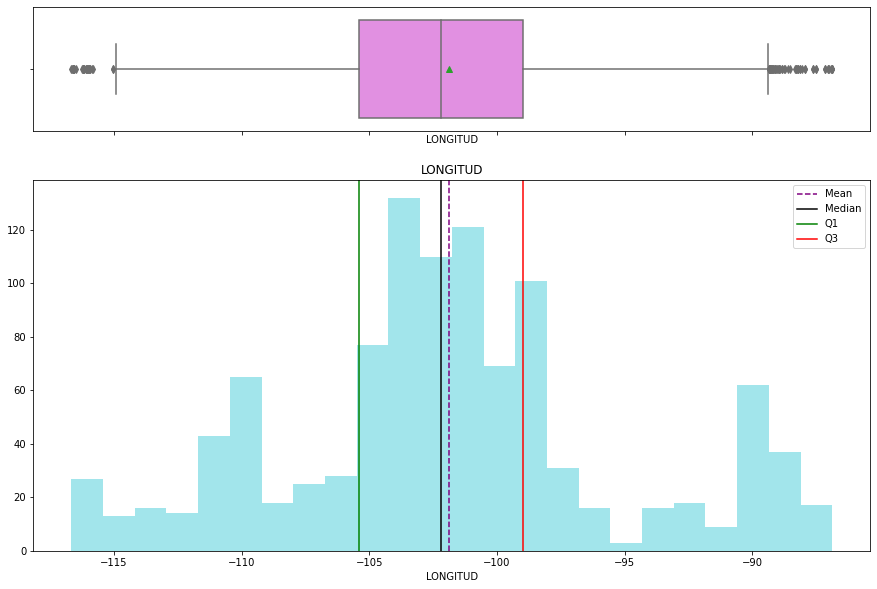

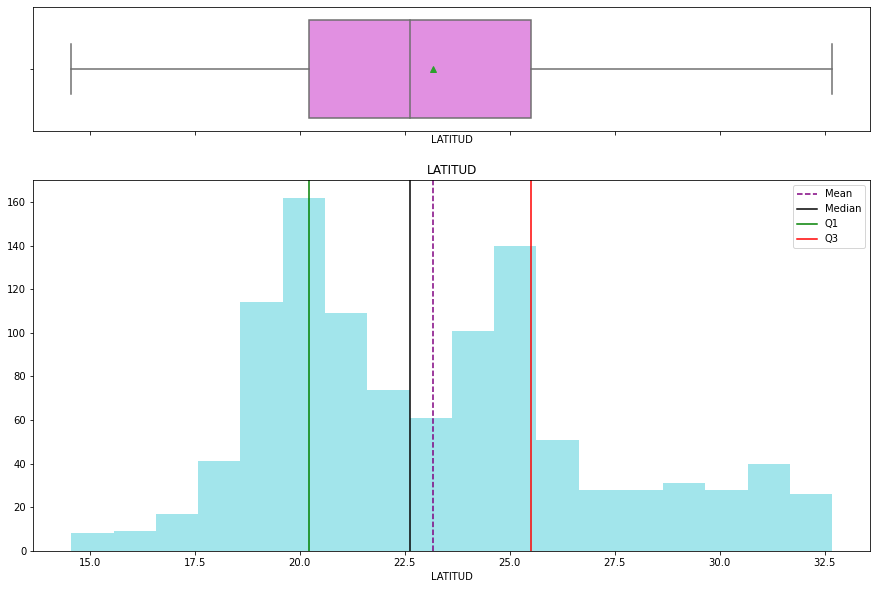

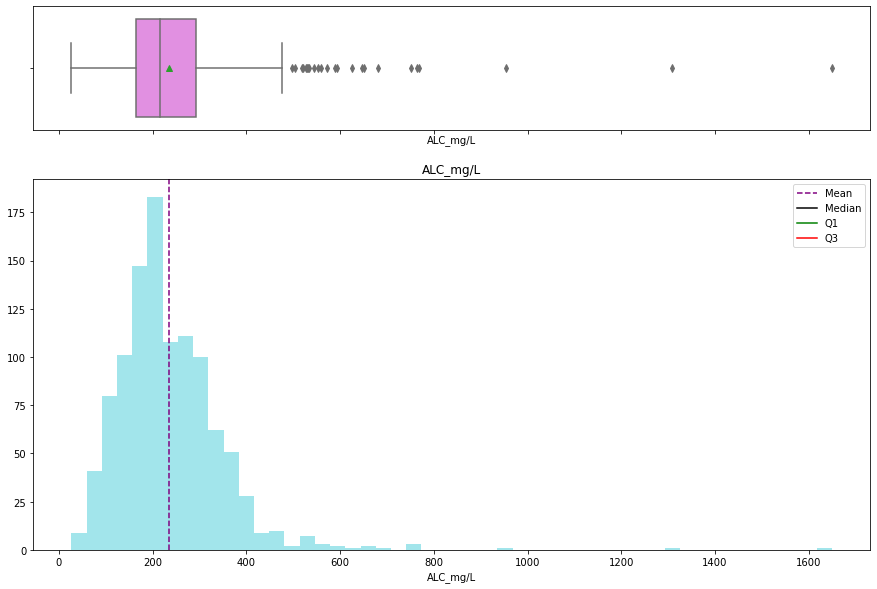

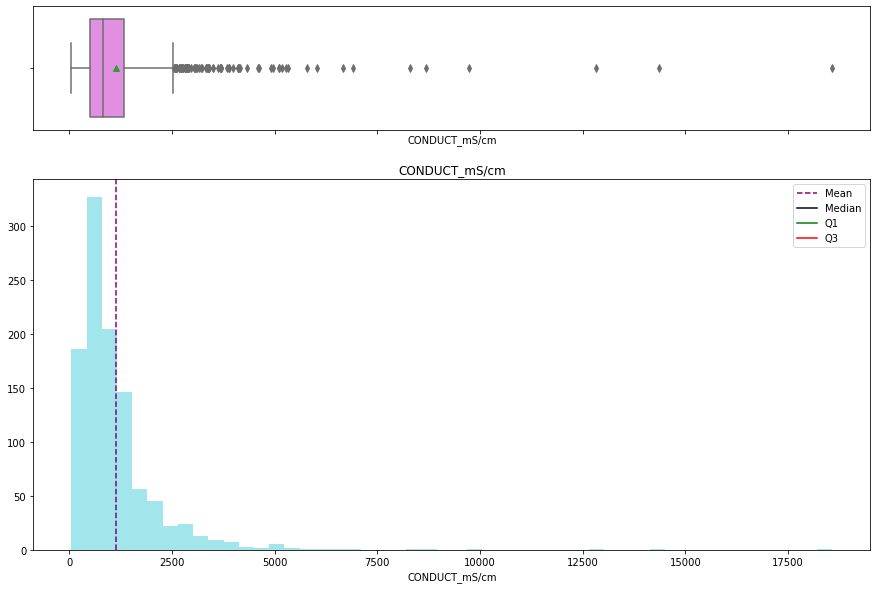

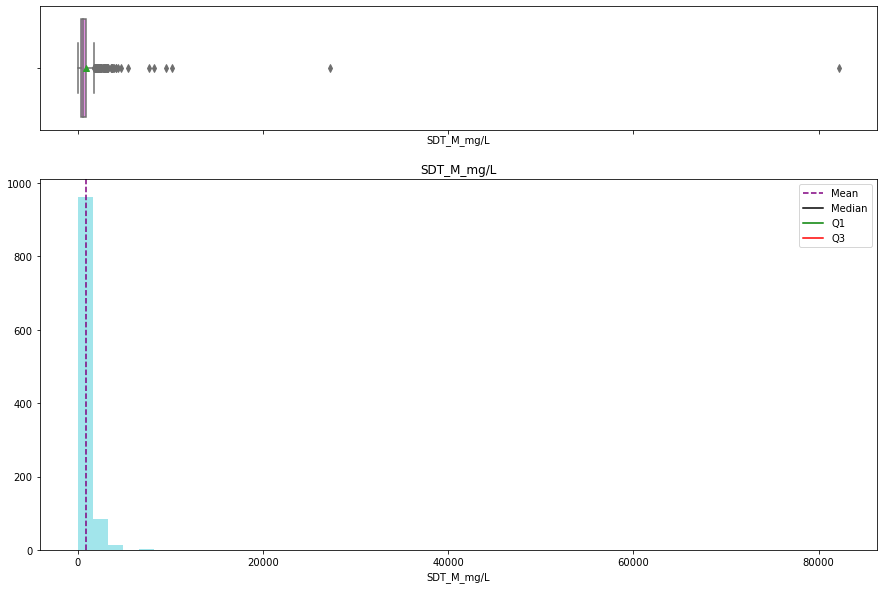

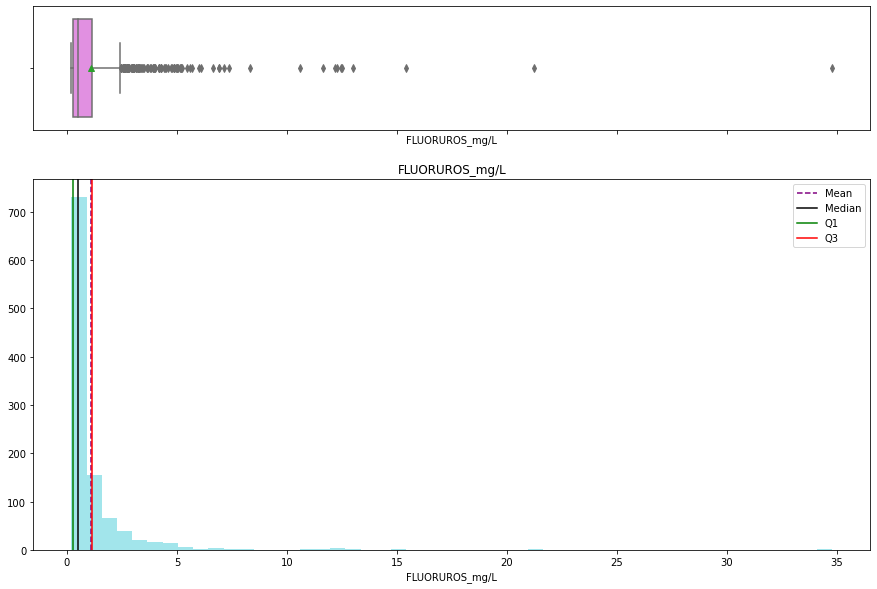

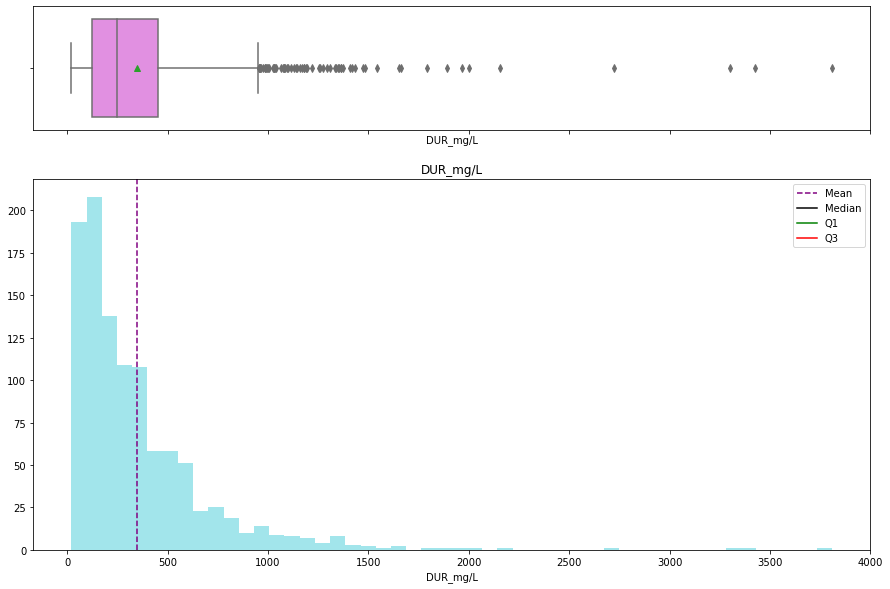

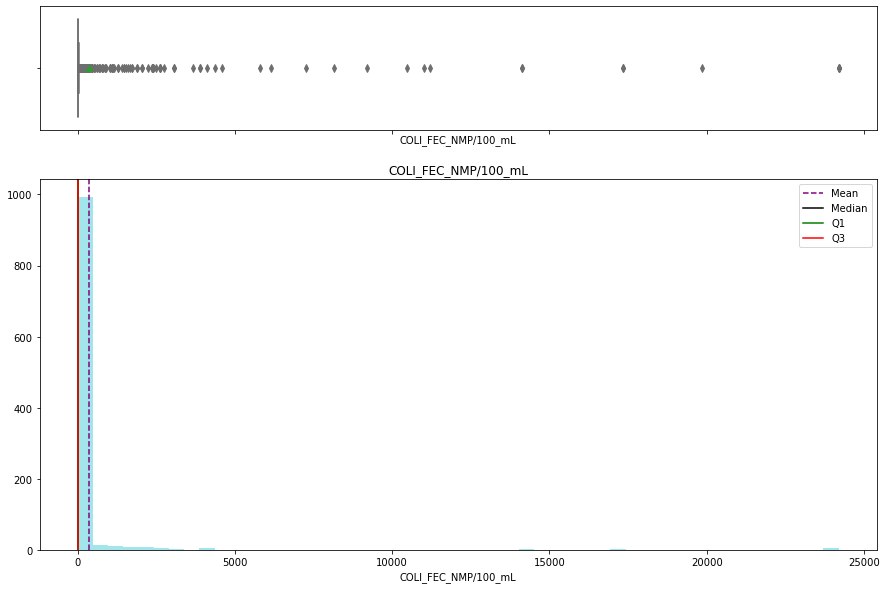

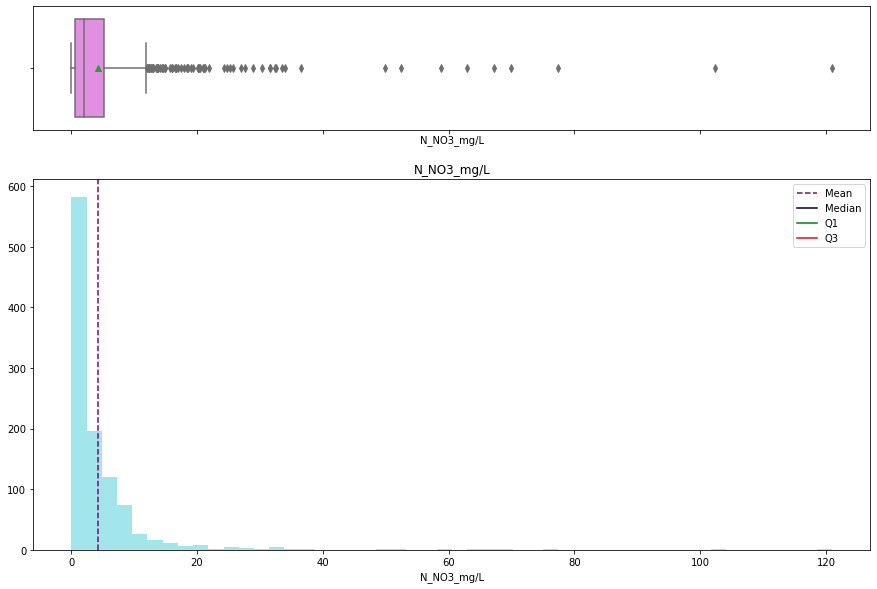

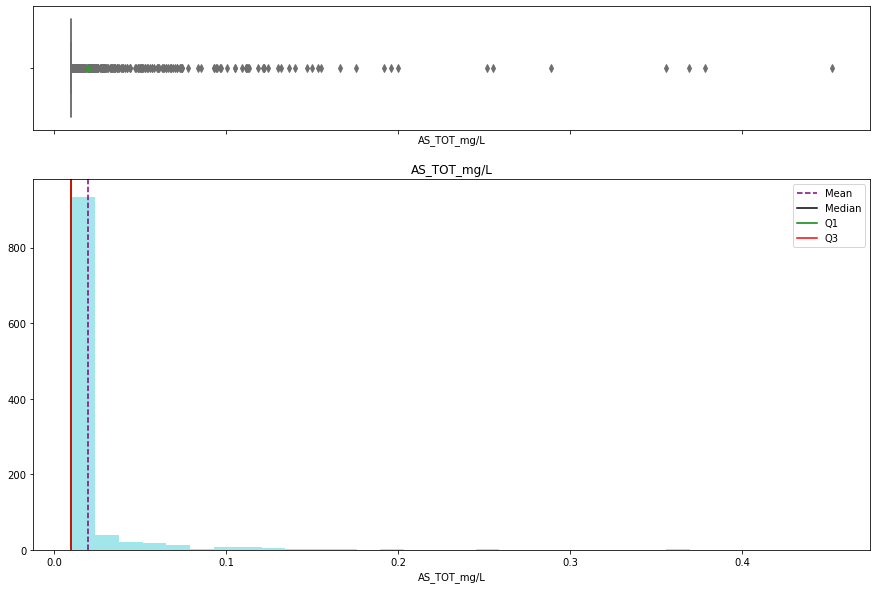

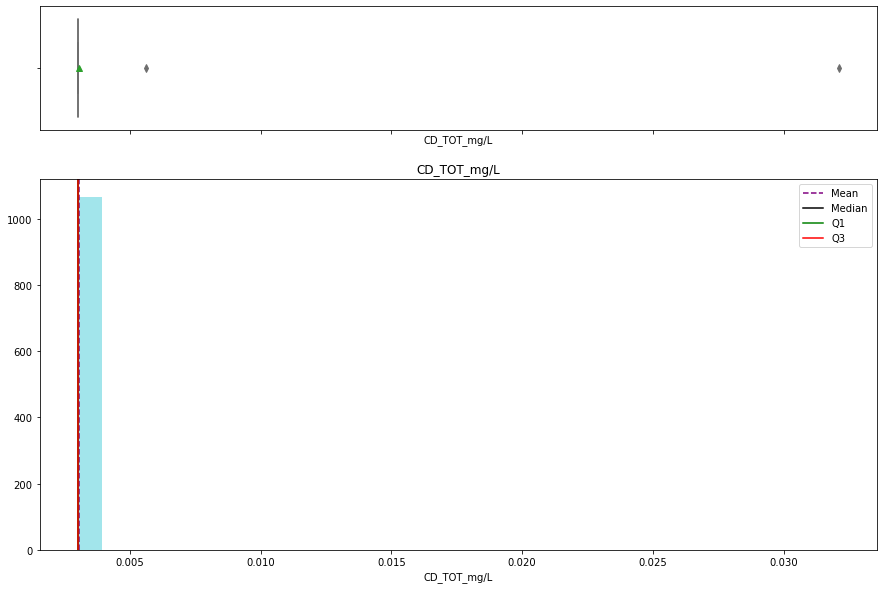

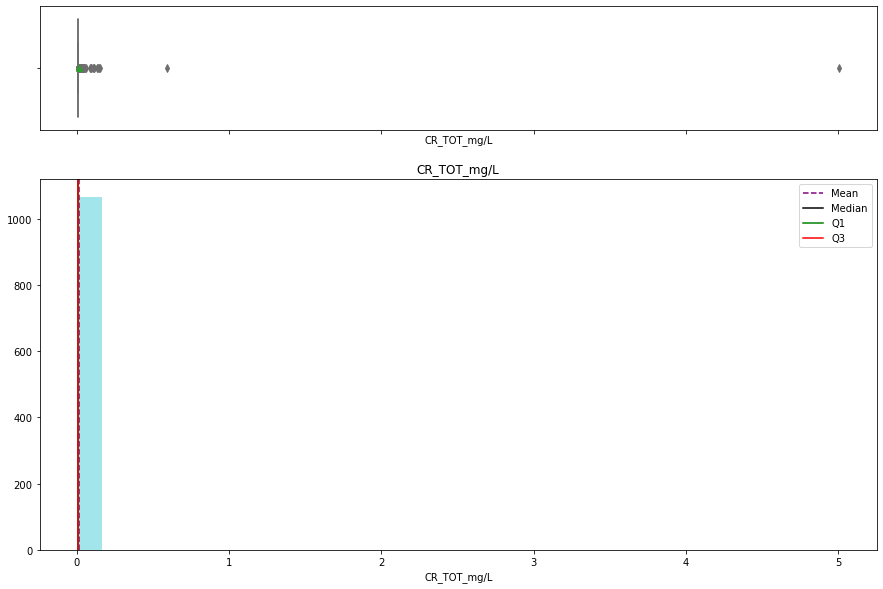

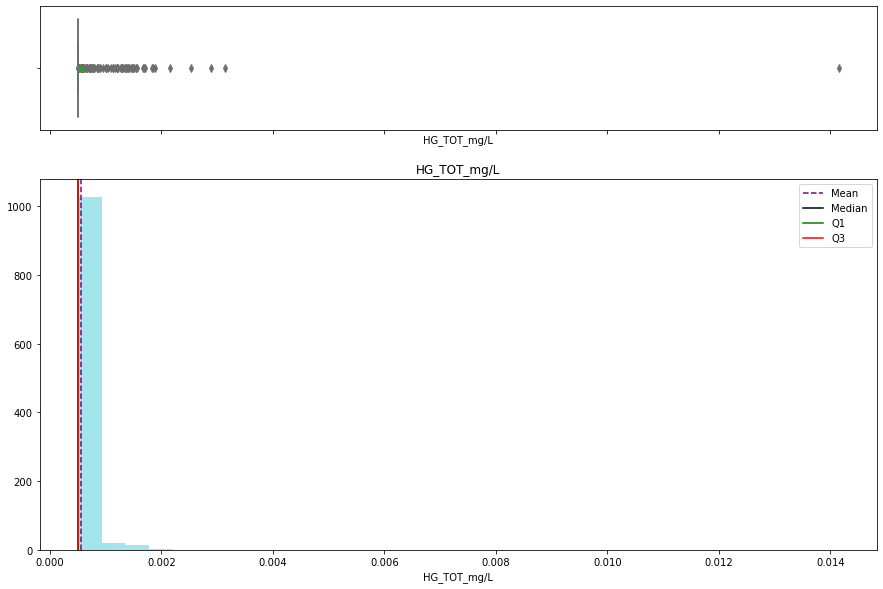

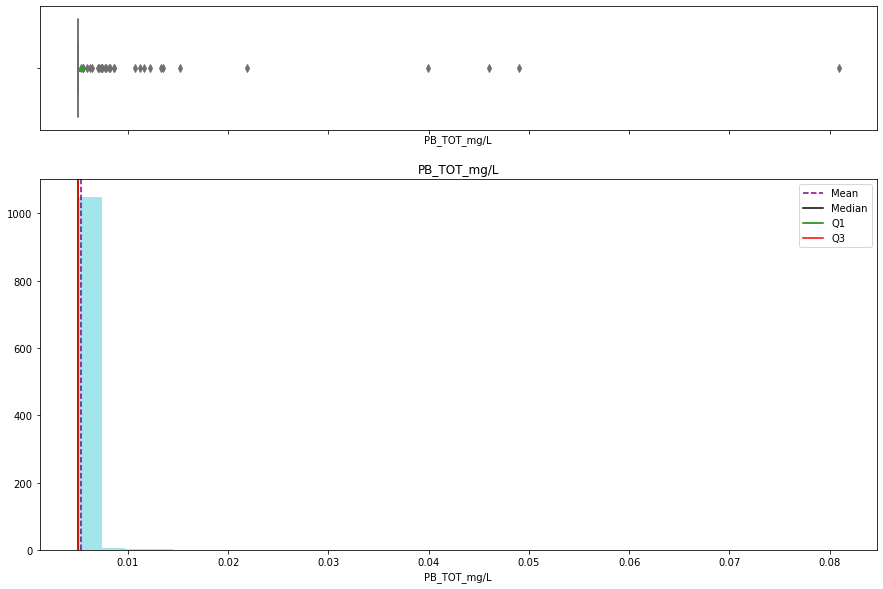

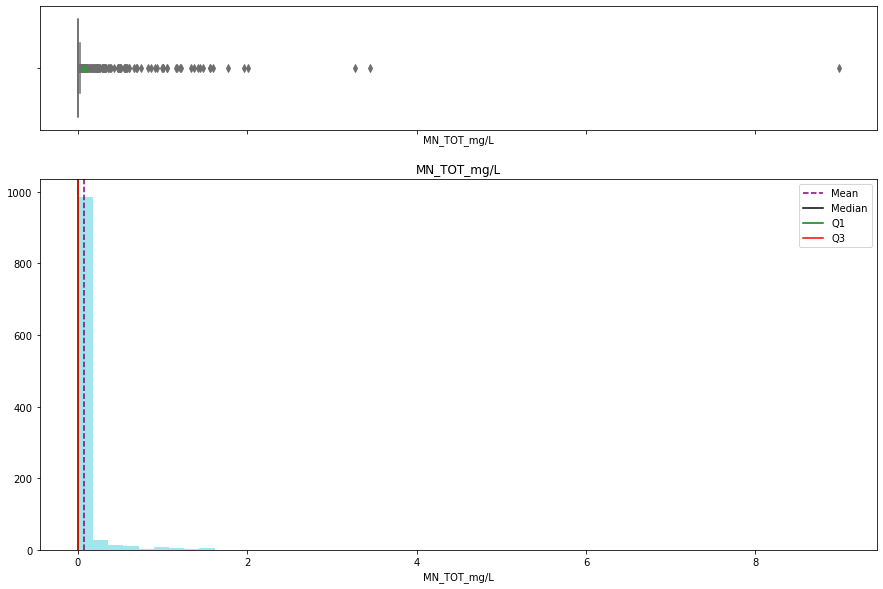

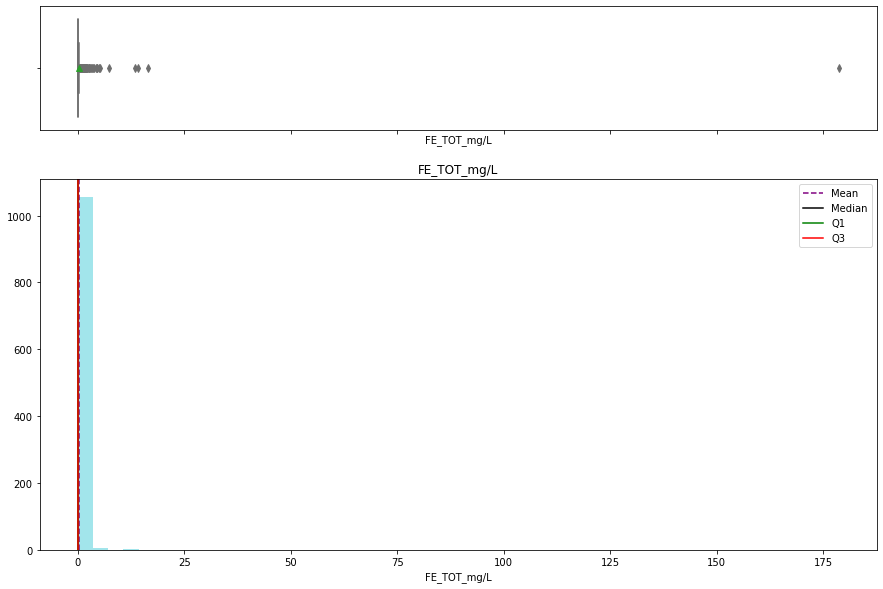

In [12]:
for col in NumCols:
    histogram_boxplot(df,col)

Podemos ver que hay un gran numero de outliers en todas las medidas por litro. Probablemente, no sea por ruido sino por casos muy aislados que se deben considerar al momento de hacer el analisis.

Dicho esto, procederemos a revisar la correlacion entre las variables numericas.

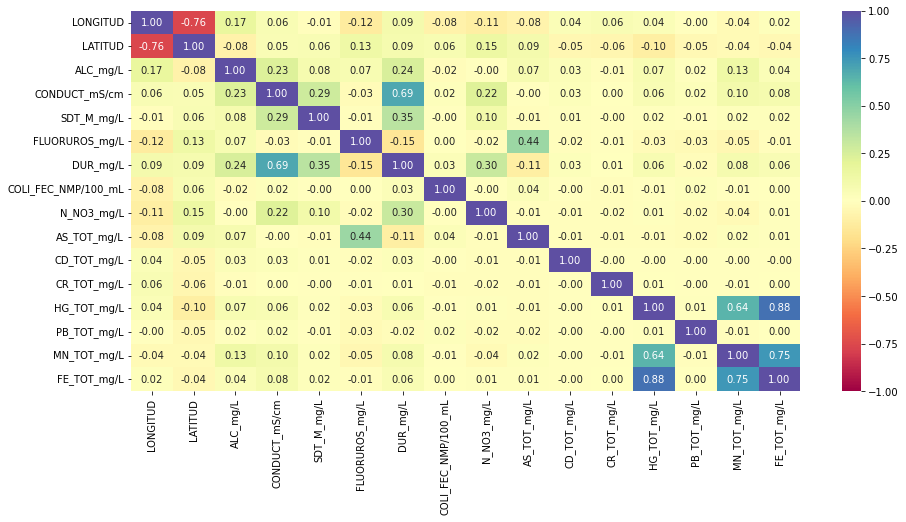

In [13]:
plt.figure(figsize=(15,7))
sns.heatmap(df[NumCols].corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='Spectral')
plt.show()

Podemos ver que existe una correlacion relativamente grande entre los contaminantes por Litro. Por ejemplo:

- Dur_mg/L vs. CONDUCT_mS/cm
- HG_TOT_mg/L vs. FE_TOT_mg/L
- MN_TOT_mg/L vs. FE_TOT_mg/L
- HG_TOT_mg/L vs. MN_TOT_mg/L

Ahora analizaremos las variables categoricas

In [14]:
print("===== Binary Columns =====")
for col in BinCols:
    print(df[col].value_counts())
print("===== Categorical Columns =====")
for col in CatCols:
    print(df[col].value_counts())
print("===== Ordinal Columns =====")
for col in OrdCols:
    print(df[col].value_counts())

===== Binary Columns =====
SI    1005
NO      59
ND       4
Name: CUMPLE_CON_ALC, dtype: int64
SI    939
NO    123
ND      6
Name: CUMPLE_CON_COND, dtype: int64
SI    995
NO     71
ND      2
Name: CUMPLE_CON_SDT_ra, dtype: int64
SI    995
NO     71
ND      2
Name: CUMPLE_CON_SDT_salin, dtype: int64
SI    876
NO    192
Name: CUMPLE_CON_FLUO, dtype: int64
SI    841
NO    226
ND      1
Name: CUMPLE_CON_DUR, dtype: int64
SI    1007
NO      61
Name: CUMPLE_CON_CF, dtype: int64
SI    985
NO     82
ND      1
Name: CUMPLE_CON_NO3, dtype: int64
SI    941
NO    127
Name: CUMPLE_CON_AS, dtype: int64
SI    1066
NO       2
Name: CUMPLE_CON_CD, dtype: int64
SI    1053
NO      15
Name: CUMPLE_CON_CR, dtype: int64
SI    1067
NO       1
Name: CUMPLE_CON_HG, dtype: int64
SI    1056
NO      12
Name: CUMPLE_CON_PB, dtype: int64
SI    982
NO     86
Name: CUMPLE_CON_MN, dtype: int64
SI    932
NO    136
Name: CUMPLE_CON_FE, dtype: int64
===== Categorical Columns =====
DLAGU6         1
OCGCE3209      1
OCFSU2

De las variables categoricas podemos ver que hay mucho trabajo por hacer.

1. En las variables binarias, vemos que hay un typo donde escribieron ND en lugar de no. Por lo tanto, convertiremos estos valores a NO


In [15]:
for col in BinCols:
    for row in range(0,df.shape[0]):
        val = str(df.loc[row,col])
        if 'ND' in val:
            df.loc[row,col] = "NO"
        
        if df.loc[row,col] == "NO":
            df.loc[row,col] = 0
        elif df.loc[row,col] == "SI":
            df.loc[row,col] = 1
    df[col] = df[col].astype("int")

2. Podemos ver que hay valores redundantes en cuanto a locación y hay otros que no nos sirven de nada para el análisis estadístico:

        a. No aportan información extra al modelo: CLAVE, SITIO
        b. Información Redundante: ESTADO, MUNICIPIO, ACUIFERO

In [16]:
df = df.drop(["CLAVE", "SITIO", "ESTADO", "MUNICIPIO", "ACUIFERO"], axis=1) 

drpCols = ["CLAVE", "SITIO", "ESTADO", "MUNICIPIO", "ACUIFERO"]
for col in drpCols:
    CatCols.pop(CatCols.index(col))

3. La columna de contaminantes contiene multiples categorias, por lo que vamos a dividirlo en multiples columnas y convertirlos en columnas binarias. Como nota extra, podemos notar que los valores NA de esta columna, estan atribuidos a todos aquellos que no tienen contaminantes.

In [17]:
# Con esto vamos a obtener todos los valores de los contaminantes
raw_cont = df["CONTAMINANTES"].dropna().unique()
# Ahora lo convertiremos en un array de una sola dimension

clean_cont = []
for cont in raw_cont:
    contArr = cont.split(",")
    for contSimp in contArr:
        if (not contSimp in clean_cont) and (contSimp != ""):
            clean_cont.append(contSimp)

#Ya con los contaminantes limpios, crearemos las columnas nuevas.
#Si contiene el contaminante le agregaremos un 1 y si no un 0

for cont in clean_cont:
    cont_cont = []
    for row in range(0,df.shape[0]):
        val = str(df.loc[row,"CONTAMINANTES"])
        if cont in val:
            cont_cont.append(1)
        else:
            cont_cont.append(0)
            
    df["CONT_"+cont] = cont_cont

## Hecho esto, podemos eliminar la columna de contaminantes
df = df.drop("CONTAMINANTES", axis=1) 
CatCols.pop(CatCols.index("CONTAMINANTES"))

'CONTAMINANTES'

4. En el Subtipo de acuifero, hay valores que solo tienen un typo. Por lo que solo se requiere corregirlos. Y hay unos que son bi-clase, por lo que podemos juntarlos

In [18]:
for row in range(0,df.shape[0]):
    val = str(df.loc[row,"SUBTIPO"]).upper()
    if val == "NORIA" or val == "POZO NORIA":
        df.loc[row,"SUBTIPO"] = "POZO/NORIA"
    elif val == "BOMBEO CENOTE":
        df.loc[row,"SUBTIPO"] = "CENOTE"
    else:
        df.loc[row,"SUBTIPO"] = val
        
df["SUBTIPO"].value_counts()        


POZO          1040
MANANTIAL       12
CENOTE           8
POZO/NORIA       7
DESCARGA         1
Name: SUBTIPO, dtype: int64

5. Haremos el encoding de las variables categóricas, convirtiendolas de alfanuméricas a numéricas

In [19]:
DicCat = {}
cat_na = CatCols + BinCols + OrdCols
for col in cat_na:
    print("=== MAPPING FOR "  + col + " ===")
    if str(df[col].dtypes) == "object":
        uni = list(df[col].unique())
        i = 0
        CurrDic = {}
        for val in uni:
            if str(val) != "nan":
                CurrDic[val] = i
                print(" => " + str(val) + ": " + str(i))
                i+=1
        DicCat[col] = CurrDic
    else:
        uni = list(df[col].unique())
        i = 0
        CurrDic = {}
        for val in uni:
            if str(val) != "nan":
                CurrDic[val] = val
                print(" => " + str(val) + ": " + str(val))
                i+=1
        DicCat[col] = CurrDic
    df[col] = df[col].map(CurrDic).astype('Int32')

=== MAPPING FOR ORGANISMO_DE_CUENCA ===
 => LERMA SANTIAGO PACIFICO: 0
 => PENINSULA DE BAJA CALIFORNIA: 1
 => PENINSULA DE YUCATAN: 2
 => RIO BRAVO: 3
 => CUENCAS CENTRALES DEL NORTE: 4
 => PACIFICO NORTE: 5
 => BALSAS: 6
 => PACIFICO SUR: 7
 => GOLFO NORTE: 8
 => AGUAS DEL VALLE DE MEXICO: 9
 => GOLFO CENTRO: 10
 => FRONTERA SUR: 11
 => NOROESTE: 12
=== MAPPING FOR SUBTIPO ===
 => POZO: 0
 => MANANTIAL: 1
 => POZO/NORIA: 2
 => DESCARGA: 3
 => CENOTE: 4
=== MAPPING FOR CALIDAD_SDT_salin ===
 => Potable - Dulce: 0
 => Ligeramente salobres: 1
 => Salobres: 2
 => Salinas: 3
=== MAPPING FOR CALIDAD_DUR ===
 => Potable - Dura: 0
 => Muy dura e indeseable usos industrial y domestico: 1
 => Potable - Suave: 2
 => Potable - Moderadamente suave: 3
=== MAPPING FOR CALIDAD_N_NO3 ===
 => Potable - Excelente: 0
 => Potable - Buena calidad: 1
 => No apta como FAAP: 2
=== MAPPING FOR CALIDAD_AS ===
 => Apta como FAAP: 0
 => No apta como FAAP: 1
 => Potable - Excelente: 2
=== MAPPING FOR CALIDAD_CD =

In [20]:
def inverse_mapping(Dict,Cat,dataFr):
    inv_dict = {v: k for k, v in Dict.items()}
    dataFr[Cat] = np.round(dataFr[Cat]).map(inv_dict).astype('category')

## Preprocesamiento

1. Separación de los datos en train y test

In [21]:
x = df.drop(columns = ["SEMAFORO"])
y = df["SEMAFORO"].astype('int')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=7,stratify=y)

2. Haremos la imputación de los datos faltantes. Usaremos el método de KNN Imputer

In [22]:
imputer = KNNImputer(n_neighbors=6)
#Fit and transform the train data
x_train=pd.DataFrame(imputer.fit_transform(x_train),columns=x_train.columns)

#Transform the test data 
x_test=pd.DataFrame(imputer.transform(x_test),columns=x_test.columns)

In [23]:
#Checking that no column has missing values in train or test sets
print(x_train.isna().sum())
print('-'*30)
print("Total NaN: ",x_train.isna().sum().sum())
print('='*30)
print(x_test.isna().sum())
print('-'*30)
print("Total NaN: ",x_test.isna().sum().sum())

ORGANISMO_DE_CUENCA    0
SUBTIPO                0
LONGITUD               0
LATITUD                0
ALC_mg/L               0
                      ..
CONT_CR                0
CONT_ALC               0
CONT_NI                0
CONT_HG                0
CONT_CD                0
Length: 64, dtype: int64
------------------------------
Total NaN:  0
ORGANISMO_DE_CUENCA    0
SUBTIPO                0
LONGITUD               0
LATITUD                0
ALC_mg/L               0
                      ..
CONT_CR                0
CONT_ALC               0
CONT_NI                0
CONT_HG                0
CONT_CD                0
Length: 64, dtype: int64
------------------------------
Total NaN:  0


3. Antes de regresar a su valor original las variables categóricas, haremos un balanceo de las clases usando SMOTETomek

In [24]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

4. Hecho esto haremos el mapeo inverso de las variables categóricas

In [25]:
for col in cat_na:
    if col != "SEMAFORO":
        inverse_mapping(DicCat[col],col,x_train)
        inverse_mapping(DicCat[col],col,x_test)

5. Finalmente haremos el Encoding de las categorías para evitar que alguna categoría tenga mayor peso que otra. Para esto usaremos get_dummies

In [26]:
x_train=pd.get_dummies(x_train,drop_first=True)
x_test=pd.get_dummies(x_test,drop_first=True)

x_train, x_test = x_train.align(x_test,join='left', axis=1)
x_test = x_test.fillna(0)
print(x_train.shape, x_test.shape)

(1104, 98) (161, 98)


In [27]:
#Checking that no column has missing values in train or test sets
print(x_train.isna().sum())
print('-'*30)
print("Total NaN: ",x_train.isna().sum().sum())
print('='*30)
print(x_test.isna().sum())
print('-'*30)
print("Total NaN: ",x_test.isna().sum().sum())

LONGITUD           0
LATITUD            0
ALC_mg/L           0
CONDUCT_mS/cm      0
SDT_M_mg/L         0
                  ..
CUMPLE_CON_CR_1    0
CUMPLE_CON_HG_1    0
CUMPLE_CON_PB_1    0
CUMPLE_CON_MN_1    0
CUMPLE_CON_FE_1    0
Length: 98, dtype: int64
------------------------------
Total NaN:  0
LONGITUD           0
LATITUD            0
ALC_mg/L           0
CONDUCT_mS/cm      0
SDT_M_mg/L         0
                  ..
CUMPLE_CON_CR_1    0
CUMPLE_CON_HG_1    0
CUMPLE_CON_PB_1    0
CUMPLE_CON_MN_1    0
CUMPLE_CON_FE_1    0
Length: 98, dtype: int64
------------------------------
Total NaN:  0


## Construcción del Modelo

1. Para empezar debemos definir la métrica a utilizar para obtener el mejor resultado. Usaremos métricas clásicas como Accuracy, Recall y Precision, junto con la gráfica de Precision Recall y el reporte de clasificación

In [45]:
def PrintScores(model, train, test, train_y, test_y, labels):
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = metrics.balanced_accuracy_score(train_y,pred_train)
    test_acc = metrics.balanced_accuracy_score(test_y,pred_test)
    
    train_recall = metrics.recall_score(train_y,pred_train, labels = labels, average =  'weighted')
    test_recall = metrics.recall_score(test_y,pred_test, labels = labels, average =  'weighted')
    
    
    train_precision = metrics.precision_score(train_y,pred_train, labels = labels, average =  'weighted')
    test_precision = metrics.precision_score(test_y,pred_test, labels = labels, average =  'weighted')
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
    
    print("Accuracy on training set : ",train_acc)
    print("Accuracy on test set : ",test_acc)
    print("Recall on training set : ", train_recall)
    print("Recall on test set : ",test_recall)
    print("Precision on training set : ",train_precision)
    print("Precision on test set : ",test_precision)
    return score_list

In [62]:
def DisplayConfMat(model, x_, y_real, labels = [0,1,2]):
    y_pred = model.predict(x_)
    cm = confusion_matrix(y_test, y_pred)
    display(cm)
    df_cm = pd.DataFrame(cm, index = ["Actual - " + str(i) for i in labels], columns = ["Predicted - " + str(i) for i in labels])
    
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Hyper Parameter Tuning - Decision Tree

In [30]:
# Creating pipeline
pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# Parameter grid to pass in RandomSearchCV
param_grid = {'decisiontreeclassifier__max_depth': np.arange(2,30), 
              'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 7, 10],
              'decisiontreeclassifier__max_leaf_nodes' : [2, 3, 5, 10,15],
              'decisiontreeclassifier__min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(brier_score_loss)

#Calling RandomizedSearchCV
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3) 
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=kfold, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(x_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'decisiontreeclassifier__min_samples_leaf': 5, 'decisiontreeclassifier__min_impurity_decrease': 0.001, 'decisiontreeclassifier__max_leaf_nodes': 15, 'decisiontreeclassifier__max_depth': 18} with CV score=nan:


### Generación de Modelo

Ya con los valores obtenidos, podemos generar un modelo "óptimo"

In [31]:
dtree = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(
        max_depth=18,
        max_leaf_nodes=15,
        random_state=1,
        min_impurity_decrease=0.001,
        min_samples_leaf=5
    ),
)

dtree.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=18, max_leaf_nodes=15,
                                        min_impurity_decrease=0.001,
                                        min_samples_leaf=5, random_state=1))])

### Generación de Métricas

Accuracy on training set :  0.9737318840579711
Accuracy on test set :  0.9539429711843505
Recall on training set :  0.9737318840579711
Recall on test set :  0.9565217391304348
Precision on training set :  0.9739704246370913
Precision on test set :  0.9574689231439804


array([[65,  1,  0],
       [ 0, 54,  4],
       [ 0,  2, 35]], dtype=int64)

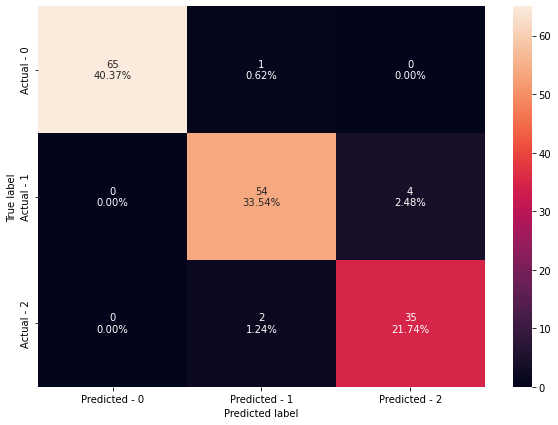

In [63]:
# Calculating different metrics
PrintScores(dtree,x_train,x_test,y_train,y_test,labels = [0,1,2])

# Creating confusion matrix
DisplayConfMat(dtree, x_test, y_test, labels = [0,1,2])

##### 

Inicialmente podemos decir que el modelo está funcionando de una manera muy buena, dandonos un overall de las métricas por arriba del 90% tanto en datos de prueba, como de entrenamiento. 

Haremos el reporte de clasificación y el análisis de la gráfica de Precision Recall.

In [70]:
from sklearn.metrics import classification_report
y_pred = dtree.predict(x_test)

print(classification_report(y_test, y_pred, target_names=["Grupo " + str(i) for i in [0,1,2]]))

              precision    recall  f1-score   support

     Grupo 0       1.00      0.98      0.99        66
     Grupo 1       0.95      0.93      0.94        58
     Grupo 2       0.90      0.95      0.92        37

    accuracy                           0.96       161
   macro avg       0.95      0.95      0.95       161
weighted avg       0.96      0.96      0.96       161



La tabla de precision recall, reafirma lo que habiamos visto con el confusion matrix. 

Ahora procederemos con la gráfica de precision recall.

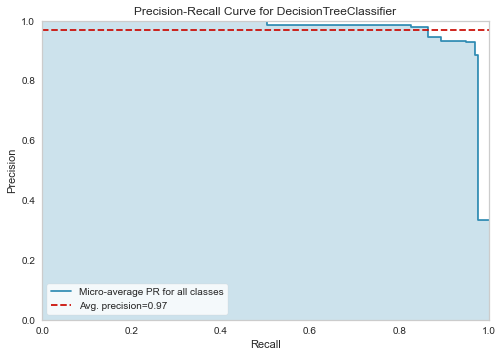

<AxesSubplot:title={'center':'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [77]:
from yellowbrick.classifier import PrecisionRecallCurve
viz = PrecisionRecallCurve(dtree)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

Una vez más podemos ver que el modelo funciona de manera esperada, con un alto nivel de confiabilidad. 